In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from inception import *
from models import *
from ucr import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [11]:
DATAPATH = Path.cwd()/'Univariate_arff'

In [12]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ACSF1'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteX'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteY'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteZ'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ArrowHead'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BME'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Beef'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BeetleFly'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BirdChicken'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CBF'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/C

In [13]:
task = 'Wine'
df_train, df_test = load_df(DATAPATH, task)

In [14]:
num_classes = df_train.target.nunique(); num_classes

2

# DL

In [15]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [16]:
x_train.shape, x_test.shape

((57, 234), (54, 234))

In [17]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [18]:
db = create_databunch(tr_ds, val_ds, 8)

Testing dims at input/output

In [22]:
for tx, ty in db.train_dl:
    print(tx.shape, ty.shape)

torch.Size([8, 1, 234]) torch.Size([8])
torch.Size([8, 1, 234]) torch.Size([8])
torch.Size([8, 1, 234]) torch.Size([8])
torch.Size([8, 1, 234]) torch.Size([8])
torch.Size([8, 1, 234]) torch.Size([8])
torch.Size([8, 1, 234]) torch.Size([8])
torch.Size([8, 1, 234]) torch.Size([8])


## Inception Time

In [17]:
# model = create_inception(1, num_classes)

In [30]:
model = create_inception_resnet(1, num_classes, kss=[3,5,7], conv_sizes=[64, 128, 256], stride=1)

In [31]:
model

Sequential(
  (0): InceptionModule(
    (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (conv2): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (conv3): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (conv_bottle): Sequential(
      (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (1): Conv1d(1, 16, kernel_size=(1,), stride=(1,), bias=False)
    )
    (bn_relu): Sequential(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), paddi

In [32]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


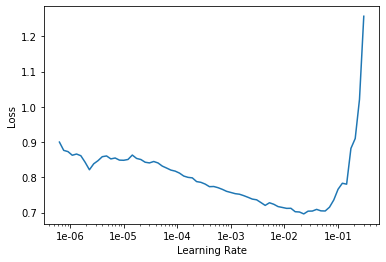

In [33]:
learn_res.lr_find(); learn_res.recorder.plot()

In [34]:
learn_res.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.819438,0.740967,0.520833,00:00
1,0.755748,0.844862,0.541667,00:00
2,0.705958,0.760367,0.458333,00:00
3,0.669713,0.705827,0.500000,00:00
4,0.638477,0.712015,0.479167,00:00
5,0.621042,0.735806,0.541667,00:00
6,0.603944,2.362440,0.541667,00:00
7,0.604532,1.490723,0.500000,00:00
8,0.608722,3.628331,0.520833,00:00
9,0.590518,6.608151,0.541667,00:00


In [35]:
p, t = learn_res.get_preds()

In [36]:
error_rate(p,t)

tensor(0.2083)

In [37]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

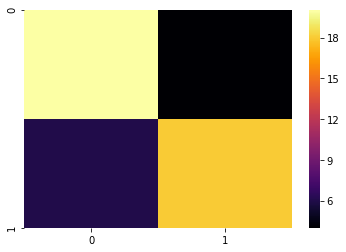

In [38]:
sns.heatmap(get_cm(p,t), cmap='inferno')